In [1]:
#imports 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pydot

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
print(tf.__version__)

2.3.0


In [2]:
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
df = pd.read_excel(URL)
df = df.sample(frac=1).reset_index(drop = True)
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.74,686.0,245.0,220.5,3.5,5,0.40,3,13.78,16.60
1,0.76,661.5,416.5,122.5,7.0,4,0.10,4,33.09,33.89
2,0.71,710.5,269.5,220.5,3.5,3,0.25,1,12.65,15.85
3,0.76,661.5,416.5,122.5,7.0,3,0.10,1,32.12,34.07
4,0.64,784.0,343.0,220.5,3.5,3,0.40,5,18.19,20.21


In [3]:
#getting some statistics
df.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307195,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090204,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


## Preparing the data

In [4]:
#Train test split
x_train, x_test = train_test_split(df, test_size = 0.2)

#train values
Y1_train = np.array(x_train["Y1"])
Y2_train = np.array(x_train["Y2"])

#test values
Y1_test = np.array(x_test["Y1"])
Y2_test = np.array(x_test["Y2"])

#remove the target values from the dataset
x_train = x_train.drop(["Y1","Y2"], axis = 1)
x_test = x_test.drop(["Y1","Y2"], axis = 1)

#Normalizing the data set
x_train_norm = (x_train-x_train.mean())/x_train.std()
x_test_norm = (x_test-x_test.mean())/x_test.std()

## Building the model

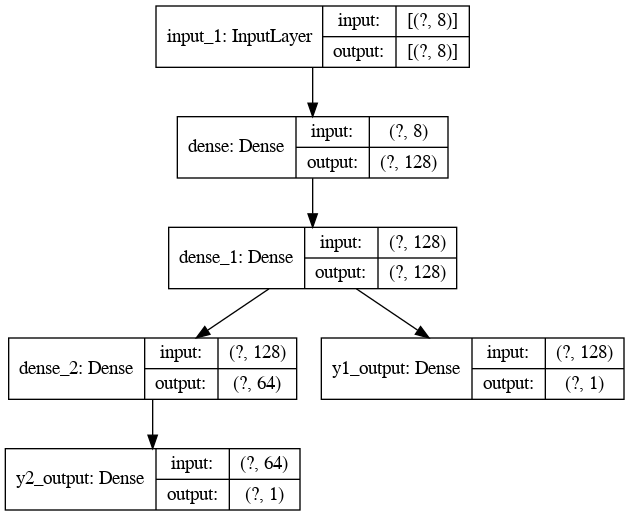

In [5]:
# defining layers
input_layer = Input(shape=(len(x_train.columns)))
dense_layer_1 = Dense(units = 128, activation = "relu")(input_layer) 
dense_layer_2 = Dense(units = 128, activation = "relu")(dense_layer_1)
dense_layer_3 = Dense(units = 64, activation = "relu")(dense_layer_2)

#Y1 output
y1_output = Dense(units = 1, activation = "linear", name = "y1_output")(dense_layer_2)

#Y2 output
y2_output = Dense(units = 1, activation = "linear", name = "y2_output")(dense_layer_3)

#Define the model with the input layer and a list of outputs
model = Model(inputs = input_layer, outputs = [y1_output, y2_output])

#specify the optimizer and compile with the loss function for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)

model.compile(optimizer = optimizer,
              loss = {'y1_output':'mse', 'y2_output':'mse'},
              metrics = {
                  'y1_output':tf.keras.metrics.RootMeanSquaredError(),
                  'y2_output':tf.keras.metrics.RootMeanSquaredError(),
              }
             )
plot_model(model, show_shapes=True )

In [6]:
#training process
history = model.fit(x_train_norm, (Y1_train, Y2_train), epochs = 2000, batch_size = 10,
                    validation_data = (x_test_norm, (Y1_test, Y2_test)), verbose = 0)

In [7]:
#testing process
loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse = model.evaluate(x = x_test_norm, y = (Y1_test, Y2_test), verbose=0)
print(f"Loss = {loss}, Y1_loss = {Y1_loss}, Y1_rmse = {Y1_rmse}, \n Y2_loss = {Y2_loss}, Y2_rmse = {Y2_rmse}")

Loss = 1.681755542755127, Y1_loss = 0.689103901386261, Y1_rmse = 0.9926515817642212, 
 Y2_loss = 0.8301228284835815, Y2_rmse = 0.9963189959526062


In [8]:
history.history.keys()

dict_keys(['loss', 'y1_output_loss', 'y2_output_loss', 'y1_output_root_mean_squared_error', 'y2_output_root_mean_squared_error', 'val_loss', 'val_y1_output_loss', 'val_y2_output_loss', 'val_y1_output_root_mean_squared_error', 'val_y2_output_root_mean_squared_error'])

In [9]:
def plot_line(metric_1,metric_2, title, label1, label2):
    plt.figure(figsize=(16,6))
    plt.title(title, fontsize = 16)
    plt.plot(metric_1, label = label1)
    plt.plot(metric_2, label = label2)
    plt.xlabel("Epochs", fontsize = 14)
    plt.grid()
    plt.legend(loc= "best")
    
def scatter_plot(true, predictions, title):
    plt.figure(figsize=(16,6))
    plt.scatter(predictions, true)
    plt.title(title, fontsize = 16)
    plt.xlabel("Predictions", fontsize = 14)
    plt.ylabel("Real", fontsize = 14)
    plt.grid()

loss = history.history["loss"]
y1_output_loss = history.history["y1_output_loss"]
y2_output_loss = history.history["y2_output_loss"]
y1_output_rmse = history.history["y1_output_root_mean_squared_error"]
y2_output_rmse = history.history["y2_output_root_mean_squared_error"]

val_loss = history.history["loss"]
val_y1_output_loss = history.history["val_y1_output_loss"]
val_y2_output_loss = history.history["val_y2_output_loss"]
val_y1_output_rmse = history.history["val_y1_output_root_mean_squared_error"]
val_y2_output_rmse = history.history["val_y2_output_root_mean_squared_error"]


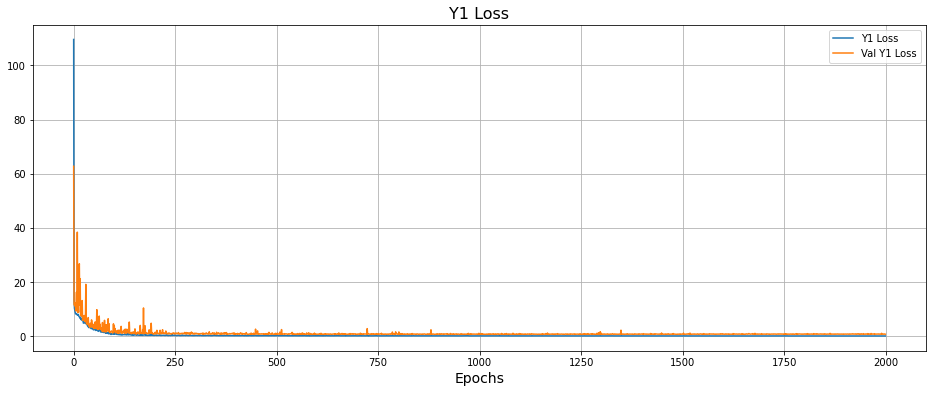

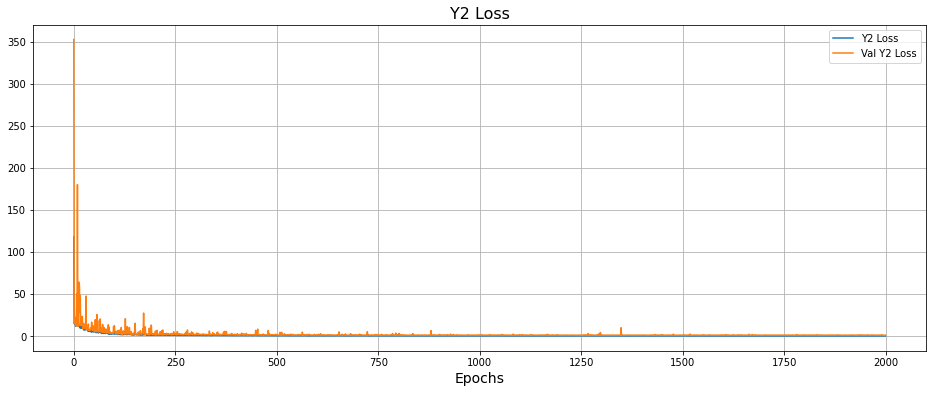

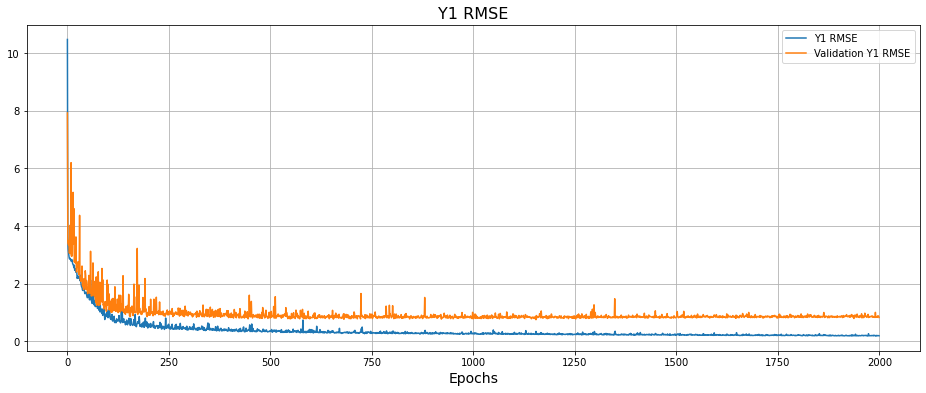

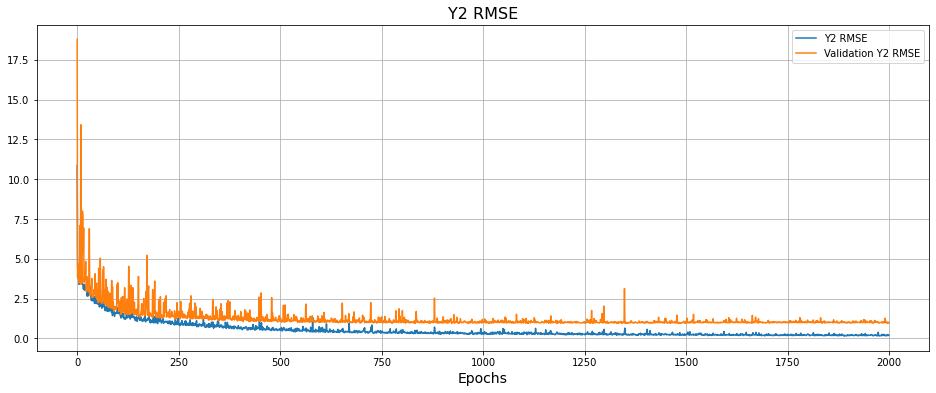

In [10]:
plot_line(y1_output_loss, val_y1_output_loss, title ="Y1 Loss", label1 = "Y1 Loss", label2 = "Val Y1 Loss")
plot_line(y2_output_loss, val_y2_output_loss, title ="Y2 Loss", label1 = "Y2 Loss", label2 = "Val Y2 Loss")
plot_line(y1_output_rmse, val_y1_output_rmse, title ="Y1 RMSE", label1 = "Y1 RMSE", label2 = "Validation Y1 RMSE")
plot_line(y2_output_rmse, val_y2_output_rmse, title ="Y2 RMSE", label1 = "Y2 RMSE", label2 = "Validation Y2 RMSE")

In [11]:
Y1_pred , Y2_pred = model.predict(x_test_norm)

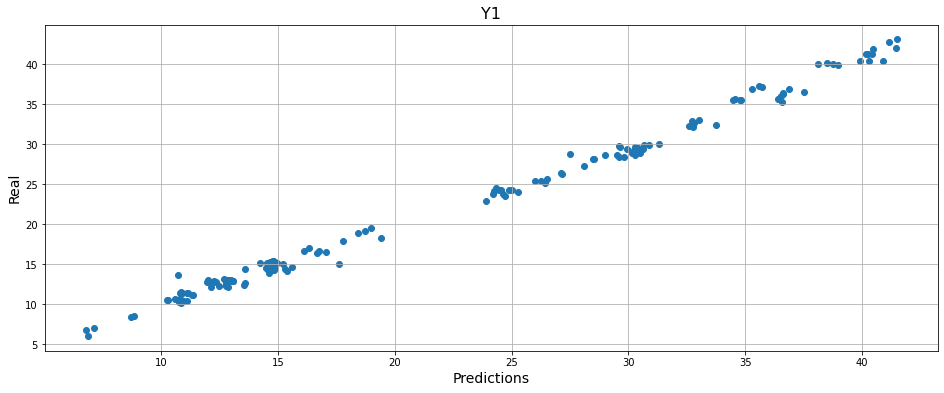

In [12]:
scatter_plot(Y1_test, Y1_pred, "Y1")

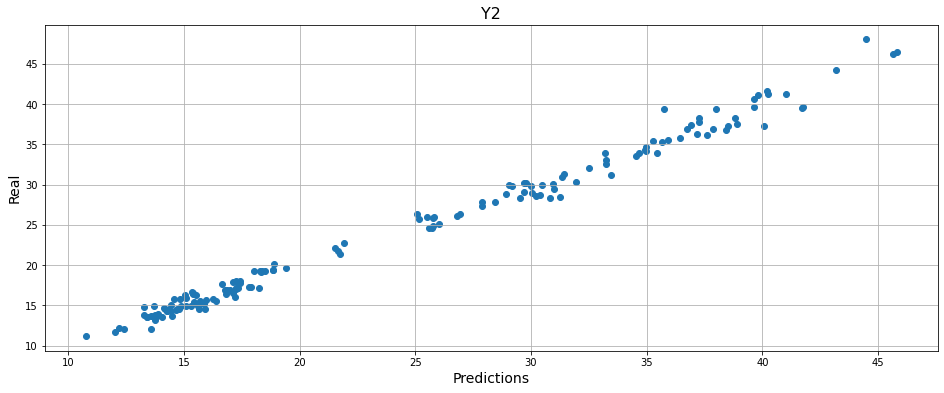

In [13]:
scatter_plot(Y2_test, Y2_pred, "Y2")

In [14]:
saving the model
model.save("multi-target-regressor")